# Kalman Filters

The first experiment to implement a working 1D Kalman Filter is the tracking a dog problem. Let us discuss the problem first. 

Someone created an RFID tracker that is reasonably accurate on a hallway that is 100m long. The sensor returns the distance of the dog from the left end of the hallway. The errors in the measurement are evenly distributed on both sides of the measurement. 

In [45]:
import math
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [26]:
class DogSensor(object):
    def __init__(self, x0=0, velocity=1, noise=0.0):
        self.x = x0
        self.velocity = velocity
        self.noise = math.sqrt(noise)
    
    def sense(self):
        self.x = self.x + self.velocity
        return self.x + np.random.randn() * self.noise

def test_sensor(noise_scale):
    dog = DogSensor(noise=noise_scale)
    xs = []
    for i in range(100):
        x = dog.sense()
        xs.append(x)
    # --
    plt.figure(figsize=(12, 4))
    plt.plot(xs, label="Sensor")
    plt.plot([0, 99], [1, 100], "r--", label="actual")
    plt.xlabel("Time")
    plt.ylabel("Pos")
    plt.ylim([0, 100])
    plt.title("Noise = %s" % (noise_scale))
    plt.legend()
    plt.show()

The above is a model of the sensor. It generates the location of the dog by propelling it forward at a velocity of 1 m/time. However, since the sensor is noisy, there is a random error attached to the sensor value. The result would be a value of position from the left side of the hall that changes quite randomly. At no noise, the sensor is quite linear so the velocity is directly translated to the position of the sensor. 

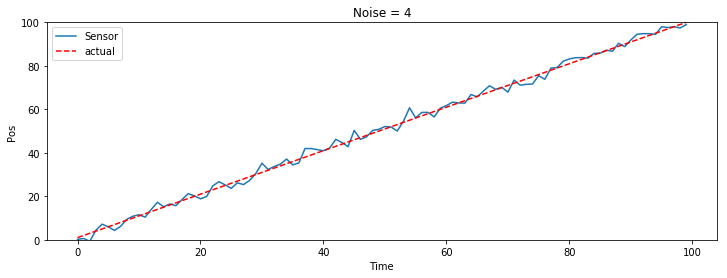

In [27]:
test_sensor(4)

As the noise increases, the variation of the actual signal increases. I.E, we are more uncertain about the position as the value fluctuates a lot due to the noise.

## Math with Gaussians

If we believe that the dog is at 23 meters and the variance is 5, the position now is $= N(23, 5)$. This can be represented as a plot.

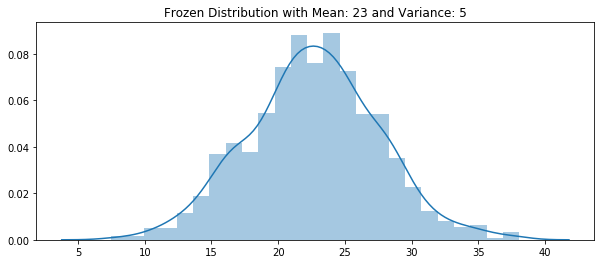

In [47]:
mean = 23
var = 5
# --
norm = stats.norm(loc=23, scale=5)
x = norm.rvs(1000)
# --
plt.figure(figsize=(10, 4))
plt.title("Frozen Distribution with Mean: {mean} and Variance: {var}".format(mean=mean,
                                                                             var=var))
sns.distplot(x)
plt.show()

When we have enough measurements at a fixed temperature, we know whether the sensor responds with the same value every time. If it does, then, we are quite confident that the value is indeed somewhere near the actual value it first showed. The question now is whether the dog actually did not move the resultant position should be noisy without any movement. 

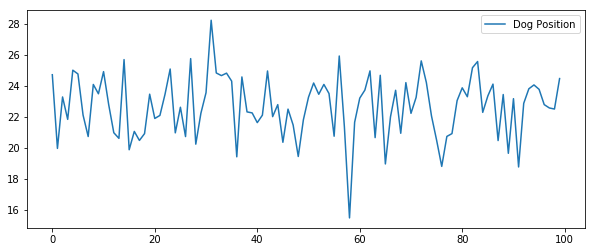

In [48]:
dog = DogSensor(23, 0, 5)
xs = range(100)
ys = []
for i in xs:
    ys.append(dog.sense())
# --
plt.figure(figsize=(10, 4))
plt.plot(xs, ys, label="Dog Position")
plt.legend()
plt.show()

The above position shows that no dog will actually move like that in real life where they move between different positions continuously for length of time. The idea now is to solve the data mathematically. From the Discrete Bayes Filter, the code adds a measurement to an existing belief and updates the belief. This method essentially computes the following:

```
new_belief = old_belief * measurement * sensor_error
```

The above discrete filter was moving like a window and this can be updated with gaussians with the following:

```
new_gaussian = measurement * old_gaussian
```

The measurement is a actually a gaussian returned by the sensor while the old-gaussian is the gaussian of values from the previous step. If we multiply gaussians,, the result is another gaussian. The result of the algebra is:

$$
N(\mu_1, \sigma_1^2) \cdot N(\mu_2, \sigma_2^2) = N\left( \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1}{\sigma_1^2 + \sigma_2^2}, \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}} \right)
$$

The new gaussian is a result of the values provided by the mean and standard deviation of the new values. The resultant expression is a combination of the means and the variances of the two input gaussians. We can also see that the variances are completely unaffected by the means of the input gaussians.

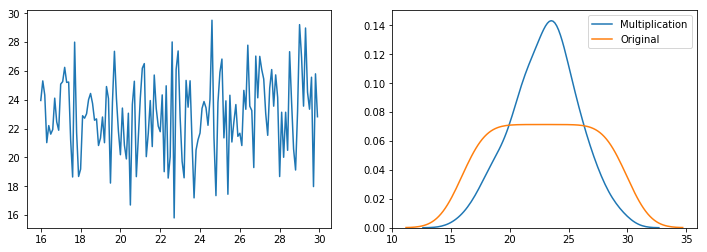

In [55]:
def multiply_Gaussian(mu1, var1, mu2, var2):
    mean = (var1*mu2 + var2*mu1) / (var1 + var2)
    variance = 1 / (1 / var1 + 1 / var2)
    return (mean, variance)
# --
xs = np.arange(16, 30, 0.1)
m1, v1 = 23, 5
m, v = multiply_Gaussian(m1, v1, m1, v1)
new_gaussian = stats.norm(loc=m, scale=v)
ys = new_gaussian.rvs(140)
# --
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(xs, ys)
plt.subplot(122)
sns.distplot(ys, hist=False, label="Multiplication")
sns.distplot(xs, hist=False, label="Original")
plt.show()

The resultant gaussian is actually taller when we multiply two of the same gaussians. This indicates that the output result is actually more accurate as we are measuring the same value or the same range of values multiple times. If I measure twice and I get the same values, then the overall range of values is actually close to the mean of those values as they are actually quite close to each other. Now, changing the multiplied gaussians to two separated while having the same variance should generate a flatter graph while multiplying.

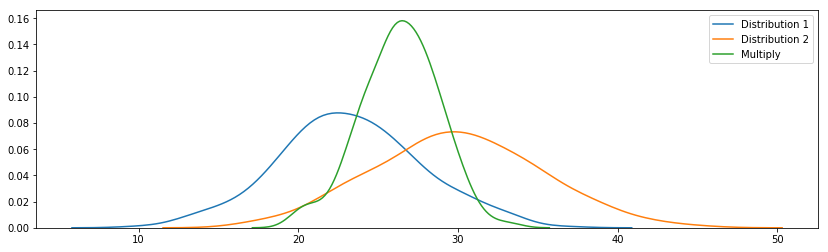

In [71]:
m1, v1 = 23, 5
m2, v2 = 30, 5
m, v = multiply_Gaussian(m1, v1, m2, v2)
# --
g_1 = stats.norm(loc=m1, scale=v1)
g_2 = stats.norm(loc=m2, scale=v2)
g_m = stats.norm(loc=m, scale=v)
# -- 
x1 = g_1.rvs(300)
x2 = g_2.rvs(300)
ys = g_m.rvs(300)
# --
plt.figure(figsize=(14, 4))
sns.distplot(x1, hist=False, label="Distribution 1")
sns.distplot(x2, hist=False, label="Distribution 2")
sns.distplot(ys, hist=False, label="Multiply")
plt.show()

One fundamental thought to keep in mind is that the measurements are accurate but with Gaussian noise. The large error that is caused by misreading the sensor is not Gaussian noise. If we have two values that separated by a large distance, then the actual value of will be the mean of the two locations. This is due to the fact that the accuracy at either value is approximately the same. This would indicate that the average of the two measurements would actually make sense even when they are separated by a large degree. If two readings have the same variance, then the actual value from the multiplication formula is that $\mu = \frac{\mu_1 + \mu_2}{2}$ which is the average of the two means. The formula works in a way that it would choose the more accurate variance rather than the least accurate value.

## Implementing Update Step

Instead of the multimodal representation in the dog problem, let us use a Gaussian to reflect the current belief of the dog's position. This Gaussian, $N(\mu, \sigma^2)$, extends to infinity in both sides and therefore covers the entire hallway therefore being unimodal. 

In [72]:
def update(mean, variance, measure, measure_variance):
    return multiply_Gaussian(mean, variance, measure, measure_variance)

The above makes sure that we are multiplying the previous estimate with our new measurement therefore giving us an idea about the position of the sensor in a much more realistic fashion. The coding practice would require to be a bit more specific as we are writing for a catch-all problem and not a specific case. Let's look into the assumption that the current belief for the dog's position is $N(2, 5)$. 

In [77]:
dog = DogSensor(velocity=0, noise=1)
pos, s = 2, 5
# --
for i in range(20):
    pos, s = update(pos, s, dog.sense(), 5)
    print("time: %d \tposition: %.3f \tvariance %.3f" % (i, pos, s))

time: 0 	position: 0.395 	variance 2.500
time: 1 	position: 0.132 	variance 1.667
time: 2 	position: -0.017 	variance 1.250
time: 3 	position: -0.369 	variance 1.000
time: 4 	position: -0.477 	variance 0.833
time: 5 	position: -0.399 	variance 0.714
time: 6 	position: -0.374 	variance 0.625
time: 7 	position: -0.265 	variance 0.556
time: 8 	position: -0.085 	variance 0.500
time: 9 	position: -0.375 	variance 0.455
time: 10 	position: -0.304 	variance 0.417
time: 11 	position: -0.260 	variance 0.385
time: 12 	position: -0.297 	variance 0.357
time: 13 	position: -0.280 	variance 0.333
time: 14 	position: -0.231 	variance 0.312
time: 15 	position: -0.135 	variance 0.294
time: 16 	position: -0.185 	variance 0.278
time: 17 	position: -0.145 	variance 0.263
time: 18 	position: -0.119 	variance 0.250
time: 19 	position: -0.087 	variance 0.238


The above is the convergence of the Kalman filter in action. As we update, the variance starts to drop as we become assured in the position of the dog while the actual position becomes clearer as it goes towards 0. We can confirm as the velocity is actually 0 and therefore the dog is sitting still.

## Implementing Predictions

The above value is still not a filter. The idea is now to predict the next element and try to update our prior belief of that state with the new measurements that the sensor records. In idea, we shift the probability vector by the amount we believe the animal moved and adjust the probability. This is Gaussian addition. If we assume that the dog was at 7.3m and he moves 2.6m to the right, the position he is currently now is 7.3 + 2.6 = 9.9m. Abstractly, the algorithm is `new_pos = old_pos + dist_moved`. In Gaussian world, the addition is performed by:

$$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$$

The physical representation indicates that as we move, the overall mean is added. I.E., the position is added as the element moves from position `A` to another position `B`. The variance however is also added. As we have updated the sensor, the confidence in the result is actually lower as we are updating the filter. We don't know where the sensor is moving and therefore the variance should be higher. 

In [78]:
def predict(pos, variance, movement, movement_variance):
    return (pos + movement, variance + movement_variance)

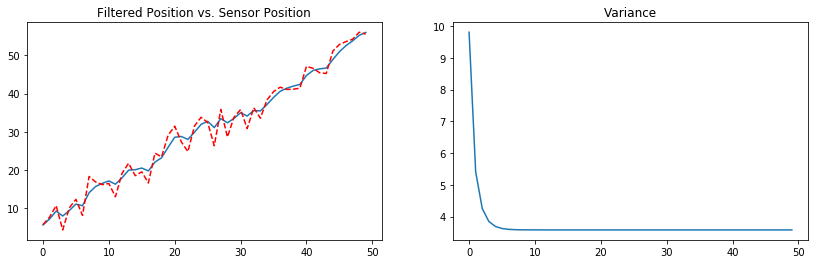

In [108]:
movement = 1
movement_error = 2
sensor_error = 10
pos = (0, 500)
# --
dog = DogSensor(5, velocity=movement, noise=sensor_error)
zs = []
ps = []
var = []
# --
for i in range(50):
    pos = predict(pos[0], pos[1], movement, movement_error)
    # print("Time: %d \tPosition: %.3f \tVariance: %.3f" % (i, pos[0], pos[1]))
    Z = dog.sense()
    zs.append(Z)
    # --
    pos = update(pos[0], pos[1], Z, sensor_error)
    # print("Time: %d \tNew Position: %.3f \tNew Variance: %.3f" % (i, pos[0], pos[1]))
    ps.append(pos[0])
    var.append(pos[1])
    # --
# --
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title("Filtered Position vs. Sensor Position")
plt.plot(ps, label="Filter")
plt.plot(zs, c="r", linestyle="dashed", label="Measure")
# --
plt.subplot(122)
plt.title("Variance")
plt.plot(var)
plt.show()

Let us break down the code:

1. Movement and Movement Error are the filter specification. We assume that the sensor moves 1 step every single time. And the error is the overall error associated with the filter we have designed.
2. Sensor Error is the actual error of the RFID sensor. Ideally, we want this to be higher than our actual error value.
3. We initiate the position by stating that we have no idea of the position, and that the variance is high enough that the value could be anywhere in the world. This uncertainty gives us the necessary uncertainty for the filter to identify the position.
4. The RFID sensor is initiated as position 0 but the value can be changed to any other value as the measurements start. 
5. The next allocation allows for outputs to be filled.
6. First we initiate out prediction for the position of the sensor according to the value we know at the start which is very little.
7. We get the first value of the sensor and we generate the approximate position according to the inaccurate sensor.
8. We now update our belief as we have new information and our prediction becomes more accurate as now we have data with lowered variance. This is the first resultant value.

The above code is a fully functional 1D Kalman filter that works completely without any issues. Now, in order to better grasp the functionality of the filter, let us create the Kalman Filter Class that is reusable.

In [109]:
class KalmanFilter1D:
    def __init__(self, x0, P, R, Q):
        """
        x0: Initial state
        P: Variance of the state
        R: Measurement error
        Q: Movement error
        """
        self.x = x0
        self.P = P
        self.R = R
        self.Q = Q
    
    def update(self, z):
        self.x = (self.P * z + self.x * self.R) / (self.P + self.R)
        self.P = 1.0 / (1.0 / self.P + 1.0 / self.R)
    
    def predict(self, u=0.0):
        self.x += u
        self.P += self.Q

## Relationship to the g-h-Filter

The takeaway of the algebra is that the `g` and `h` are fully explained / specified by the variance and the covariance of the measurement and the predictions at the time `n`. We are picking a point between the measurement and the prediction by a scale factor determined by the quality of each of those two inputs.

## Introduction to Designing a Filter

**AIM**: To design and implement a filter for a thermometer. The sensor for the thermometer outputs a voltage that corresponds to the temperature that is being measured. The specifications indicate that the sensor exhibits white noise with a standard deviation of 2.13.

- The variance is therefore $2.13^2$.

In [146]:
def voltage(tempVar):
    return np.random.randn() * tempVar + 16.3

From the specification sheets, the numbers provided are maximum errrors and therefore guarantee that the performance is at least that good. It is important to note whether the number is a maximum or whether it is a $3\sigma$ error rate or whether every item is tested. It is important to note whether the variance is normally distributed or is some other distribution. The first step is to model the sensor accurately and that is the hardest part of the Kalman filter.

In [170]:
state, state_var = (12, 30)
measure_error, move_error = (3, 0.2)
# --
N = 100
zs = [voltage(2.13**2) for i in range(N)]
# --
kf = KalmanFilter1D(x0=state, P=state_var, R=measure_error,
                    Q=move_error)
# --
ps = []
estimates = []
for i in zs:
    kf.predict(movement)
    kf.update(i)
    estimates.append(kf.x)
    ps.append(kf.P)

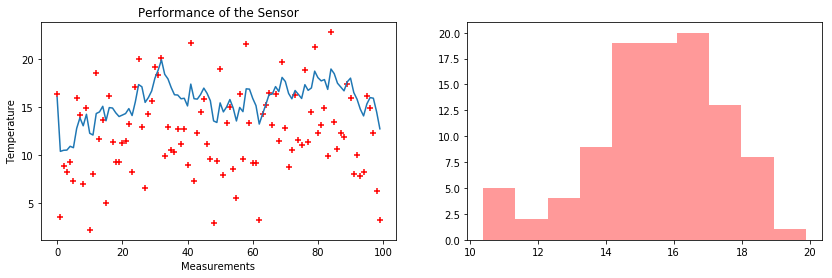

In [171]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.scatter(range(N), zs, marker="+", color="r", label="Measurments")
plt.plot(estimates, label="Start=12")
plt.title("Performance of the Sensor")
plt.xlabel("Measurements")
plt.ylabel("Temperature")
plt.subplot(122)
sns.distplot(estimates, hist=True, color="red", kde=False)
plt.show()

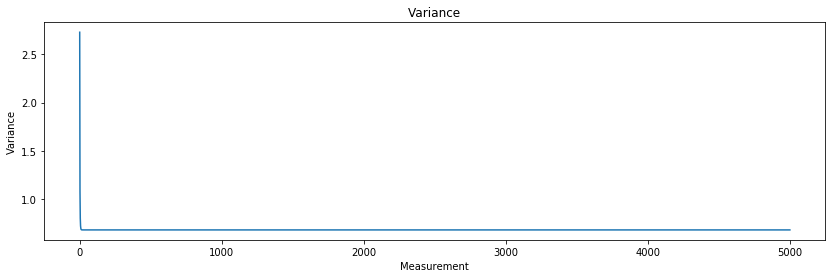

In [154]:
plt.figure(figsize=(14, 4))
plt.title("Variance")
plt.plot(ps)
plt.xlabel("Measurement")
plt.ylabel("Variance")
plt.show()

In the above code, as the data is repeated more times, the distribution of the values starts to slowly become more and more gaussian. There are a few special exercises that can be helpful in creating a better idea:

1. Extreme amounts of noise
2. Bad initial estimate
3. Large amounts of noise and bad initial estimate
4. Non-linear Sensors
5. Noisy non-linear Sensors

## Summary

- Gaussians are good representation of unimodal belief of some measured quantity.
- Multiplying gaussians is a good way to compute a new belief from your prior belief and the new measurement i.e., prediction
- Adding gaussians is a good way to update the belief i.e., update
- Try to create more filters and play around with it on more data